In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import os

## Multilayer CNN

Couche de poids paramétrable

In [4]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

convertisseur image 32 x 32

In [5]:
def mnist_reshape_32(x_batch):
    if len(x_batch.shape) > 1 :
        m, _ = x_batch.shape
        batch32 = np.zeros((m, 1024))
        for i, x in enumerate(x_batch):
            assert x.shape == (28 * 28,)
            image = x.reshape(28, 28)
            image = np.append(np.zeros((2, 28)), image, axis = 0)
            image = np.append(image, np.zeros((2, 28)), axis = 0)
            image = np.append(np.zeros((32, 2)), image, axis = 1)
            image = np.append(image, np.zeros((32, 2)), axis = 1)
            batch32[i,:] = image.reshape((32 * 32,))
    else:
        m = x_batch.shape
        batch32 = np.zeros((1024,))
        assert x_batch.shape == (28 * 28,)
        image = x_batch.reshape(28, 28)
        image = np.append(np.zeros((2, 28)), image, axis = 0)
        image = np.append(image, np.zeros((2, 28)), axis = 0)
        image = np.append(np.zeros((32, 2)), image, axis = 1)
        image = np.append(image, np.zeros((32, 2)), axis = 1)
        batch32 = image.reshape((1,32 * 32))
    return batch32 #.tolist()

## Prediction graph

Construction couche 1 : 32 x 32 --> 16 x 16

In [75]:
DEPTH1 = 8
WIDTH1 = 4
OUT1 = 32 / WIDTH1

DEPTH2 = 32
WIDTH2 = 4
OUT2 = 32 / WIDTH1 / WIDTH2

DEPTH3 = 128
WIDTH3 = 2
OUT3 = 32 / WIDTH1 / WIDTH2 / WIDTH3


#DEPTH4 = 512

#DEPTH1 = 8
#DEPTH2 = 16
#DEPTH3 = 32
#DEPTH4 = 64

STD = 1.

BATCH_SIZE = 50


TensorFlow session

Data placeholders

(les données sont empilées selon dimension 0)

In [76]:
sess = tf.InteractiveSession()

Data placeholders

(les données sont empilées selon dimension 0)

In [77]:
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
training_step = tf.placeholder(tf.float32, shape=[4])
keep_prob = tf.placeholder(tf.float32)

In [78]:
# Paramètres
W_conv1 = weight_variable([WIDTH1, WIDTH1, 1, DEPTH1], stddev = STD / (WIDTH1 * WIDTH1), name = "W_conv1")
# Input 2D reshape
x_image = tf.reshape(x, [-1, 32, 32, 1])
# Graph construction
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, WIDTH1, WIDTH1, 1], padding='VALID') 
#z_conv1 = tf.nn.relu(h_conv1)
z_conv1 = tf.nn.relu(h_conv1)

W_conv2 = weight_variable([WIDTH2, WIDTH2, DEPTH1, DEPTH2], stddev = STD / (WIDTH2 * WIDTH2 * DEPTH1), name = "W_conv2")
h_conv2 = tf.nn.conv2d(z_conv1, W_conv2, strides=[1, WIDTH2, WIDTH2, 1], padding='VALID') 
z_conv2 = tf.nn.relu(h_conv2)

W_conv3 = weight_variable([WIDTH3, WIDTH3, DEPTH2, DEPTH3], stddev = STD / (WIDTH3 * WIDTH3 * DEPTH2), name = "W_conv3")
h_conv3 = tf.nn.conv2d(z_conv2, W_conv3, strides=[1, WIDTH3, WIDTH3, 1], padding='VALID') 
z_conv3 = tf.nn.relu(h_conv3)


### Generative graph
  - incremental learning
  - ladder structure

### Readout graph

In [79]:
z_flat1 = tf.nn.dropout(tf.reshape(z_conv1, [-1, OUT1 * OUT1 * DEPTH1]), keep_prob)
z_flat2 = tf.nn.dropout(tf.reshape(z_conv2, [-1, OUT2 * OUT2 * DEPTH2]), keep_prob)
z_flat3 = tf.nn.dropout(tf.reshape(z_conv3, [-1, OUT3 * OUT3 * DEPTH3]), keep_prob)

W_out1 = weight_variable([OUT1 * OUT1 * DEPTH1, 10], stddev = STD / (OUT1 * OUT1 * DEPTH1), name = "W_out1")
W_out2 = weight_variable([OUT2 * OUT2 * DEPTH2, 10], stddev = STD / (OUT2 * OUT2 * DEPTH2), name = "W_out2")
W_out3 = weight_variable([OUT3 * OUT3 * DEPTH3, 10], stddev = STD / (OUT3 * OUT3 * DEPTH3), name = "W_out3")


y_cnn =   tf.scalar_mul(training_step[0], tf.matmul(z_flat1, W_out1)) \
        + tf.scalar_mul(training_step[1], tf.matmul(z_flat2, W_out2)) \
        + tf.scalar_mul(1- (1-training_step[2]) * (1-training_step[3]), tf.matmul(z_flat3, W_out3)) 

z_cnn = tf.nn.softmax(y_cnn)

In [80]:
W_deconv3 = weight_variable([10, OUT3 * OUT3 * DEPTH3], stddev = STD / 10, name = "W_deconv3")
z_in3 = tf.scalar_mul(training_step[3], z_cnn)
h_deconv3_flat = tf.matmul(z_in3, W_deconv3)
h_deconv3 = tf.reshape(h_deconv3_flat, [-1, OUT3, OUT3,  DEPTH3])
z_deconv3 = tf.nn.softmax(h_deconv3)

W_deconv2 = weight_variable([WIDTH3, WIDTH3, DEPTH2, DEPTH3], stddev = STD / (WIDTH3 * WIDTH3 * DEPTH2), name = "W_deconv2")
z_in2 = tf.scalar_mul(training_step[2], tf.nn.softmax(h_conv3)) \
        + tf.scalar_mul(training_step[3], z_deconv3)

h_deconv2 = tf.nn.conv2d_transpose(z_in2, W_deconv2, output_shape=[BATCH_SIZE, OUT2, OUT2, DEPTH2],
                                        strides=[1, WIDTH3, WIDTH3, 1], padding='VALID') 
z_deconv2 = tf.nn.softmax(h_deconv2)

W_deconv1 = weight_variable([WIDTH2, WIDTH2, DEPTH1, DEPTH2], stddev = STD / (WIDTH2 * WIDTH2 * DEPTH1), name = "W_deconv1")
z_in1 =   tf.scalar_mul(training_step[1], tf.nn.softmax(h_conv2)  ) \
        + tf.scalar_mul(1 - ((1 - training_step[2]) * (1 - training_step[3])), z_deconv2)
h_deconv1 = tf.nn.conv2d_transpose(z_in1, W_deconv1, output_shape=[BATCH_SIZE, OUT1, OUT1, DEPTH1],
                                        strides=[1, WIDTH2, WIDTH2, 1], padding='VALID') 
z_deconv1 = tf.nn.softmax(h_deconv1)

W_deconv0 = weight_variable([WIDTH1, WIDTH1, 1, DEPTH1], stddev = STD / (WIDTH1 * WIDTH1), name = "W_deconv0")
z_in0 =   tf.scalar_mul( training_step[0]     , tf.nn.softmax(h_conv1)   ) \
        + tf.scalar_mul( 1 - ((1 - training_step[1]) * (1 - training_step[2]) * (1 - training_step[3])) , z_deconv1)
h_deconv0 = tf.nn.conv2d_transpose(z_in0, W_deconv0, output_shape=[BATCH_SIZE, 32, 32, 1],
                                        strides=[1, WIDTH1, WIDTH1, 1], padding='VALID') 
x_deconv0 = tf.nn.sigmoid(h_deconv0)
x_out = tf.reshape(x_deconv0, [-1, 32 * 32])



## Loss graph

In [81]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_cnn))
#beta = 0
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_cnn)\
#                               + beta * (tf.nn.l2_loss(W_conv1) \
#                                      + tf.nn.l2_loss(W_conv2) \
#                                      + tf.nn.l2_loss(W_out)))

#gen_loss1 = tf.reduce_mean(tf.square(x - x_out))
#gen_loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=z_conv1, logits=h_deconv1))
#tf.reduce_mean(tf.square(z_conv1 - z_deconv1))
#gen_loss2 = tf.reduce_mean(tf.square(z_conv2 - z_deconv2))
#gen_loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=z_conv2, logits=h_deconv2))

gen_loss = tf.reduce_mean(tf.square(x - x_out))


## Train graph

In [82]:
classif_train_stage1 = tf.train.AdamOptimizer(3e-5).minimize(classif_loss, var_list = [W_conv1, W_out1])
classif_train_stage2 = tf.train.AdamOptimizer(1e-4).minimize(classif_loss, var_list = [W_conv1, W_conv2, W_out2])
classif_train_stage3 = tf.train.AdamOptimizer(1e-4).minimize(classif_loss, var_list = [W_conv1, W_conv2, W_conv3, W_out3])

gen_train_stage1 = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv0, W_conv1])
gen_train_stage2 = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv0, W_deconv1, W_conv1, W_conv2])
gen_train_stage3 = tf.train.AdamOptimizer(3e-5).minimize(gen_loss , var_list = [W_deconv0, W_deconv1, W_deconv2, W_conv1, W_conv2, W_conv3])
gen_train_stage4 = tf.train.AdamOptimizer(3e-5).minimize(gen_loss , var_list = [W_deconv0, W_deconv1, W_deconv2, W_deconv3, W_conv1, W_conv2, W_conv3])
#gen_train_step = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv1, b_deconv1, W_deconv0, b_deconv0])


# train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

## Evaluation graph

In [83]:
correct_prediction = tf.equal(tf.argmax(y_cnn, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x - x_out)))

## Training

In [84]:
turn = 1
if turn ==1:
    sess.run(tf.global_variables_initializer())

In [ ]:
saver = tf.train.Saver()

### Train session Interleaved

In [ ]:
#with tf.Session() as sess:
if True :#not os.path.isfile("models/deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-RELU-DROP.ckpt.index"):
    for rep in range(120): #120
        for i in range(20000): #2400000
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(    feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 0, 1],\
                                                                    keep_prob : 1})
                train_gen_accuracy = gen_accuracy.eval(feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 0, 1],\
                                                                    keep_prob : 1}) 
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            if i % 4 == 0:    
                classif_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [1, 0, 0, 0],\
                                                    keep_prob : .5}) 
                gen_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [1, 0, 0, 0],\
                                                keep_prob : .5}) 
            elif i % 4 == 1:
                classif_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [0, 1, 0, 0],\
                                                    keep_prob : .5}) 
                gen_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [0, 1, 0, 0],\
                                                keep_prob : .5
                                               }) 
            elif i % 4 == 2:
                classif_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [0, 0, 1, 0],\
                                                    keep_prob : .5}) 
                gen_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [0, 0, 1, 0],\
                                                keep_prob : .5}) 
            else:
                classif_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [0, 0, 0, 1],\
                                                    keep_prob : .5}) 
                gen_train_stage4.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [0, 0, 0, 1],\
                                                keep_prob : .5}) 
        saver.save(sess, "deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-RELU-DROP.ckpt")
else:
    saver.restore(sess,'models/deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-RELU-DROP.ckpt')


step 1350, training accuracy : 0.30, generative avg error : 0.4896

**Notes** :
  - Avec connectivité totale des couches forward et bakward (ladder connectivity --> effet de regularisation)
  - Connectivité selon training_step (app incremental)--> l'erreur de reconstruction stagne à 0.1
  - Connectivité selon training_step (app incremental) avec back-prop sur les liens entrants (discriminatifs)
    --> l'erreur de reconstruction descend à 0.06

In [ ]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images),\
                                                    y_: mnist.test.labels,\
                                                    training_step : [0, 0, 1, 0],\
                                                                    keep_prob : 1}))
print('test generative accuracy %g' % gen_accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images)[:50,:],\
                                                                   y_: mnist.test.labels[:50,:],\
                                                                   training_step : [0, 0, 1, 0],\
                                                                    keep_prob : 1}))

In [48]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images),\
                                                    y_: mnist.test.labels,\
                                                    training_step : [0, 0, 0, 1],\
                                                                    keep_prob : 1}))
print('test generative accuracy %g' % gen_accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images)[:50,:],\
                                                                   y_: mnist.test.labels[:50,:],\
                                                                   training_step : [0, 0, 0, 1],\
                                                                    keep_prob : 1}))

test accuracy 0.8187
test generative accuracy 0.2143


### Tests

In [49]:
training_step_test = [0, 0, 1, 0]

In [50]:
batch = mnist.test.next_batch(BATCH_SIZE) 

(1, 8, 8, 8)
(1, 2, 2, 32)
(1, 1, 1, 128)
(1, 10)


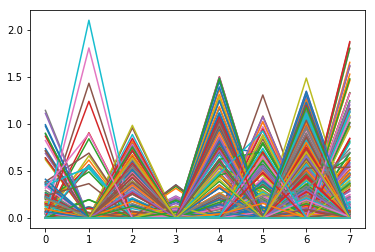

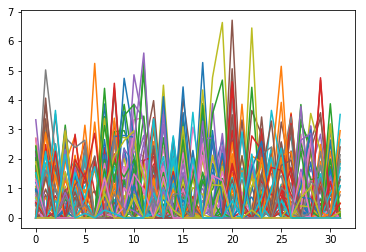

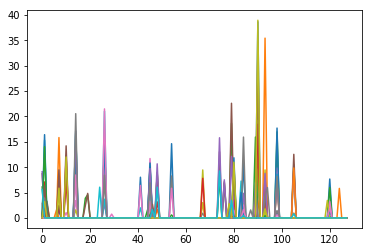

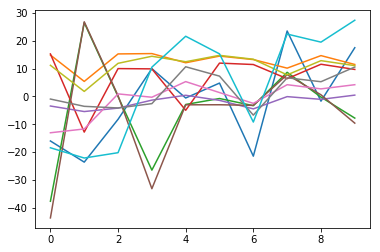

In [52]:
test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test, keep_prob : 1})
print test.shape
figure()
for k in range(30):        
    test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test, keep_prob : 1})
    for i in range(OUT1):
        for j in range(OUT1):
            plot(test[0,i,j,:])

test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test, keep_prob : 1})
print test.shape
figure()
for k in range(30):        
    test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test, keep_prob : 1})
    for i in range(OUT2):
        for j in range(OUT2):
            plot(test[0,i,j,:])

test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test, keep_prob : 1})
print test.shape
figure()
for k in range(30):        
    test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test, keep_prob : 1})
    for i in range(OUT3):
        for j in range(OUT3):
            plot(test[0,i,j,:])

test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test, keep_prob : 1})
print test.shape
figure()
for k in range(10):        
    test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test, keep_prob : 1})
    plot(test[0])


[7]
[3]
[1]
[0]
[9]
[1]
[4]
[4]
[5]
[9]


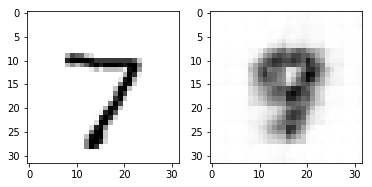

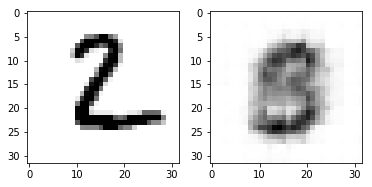

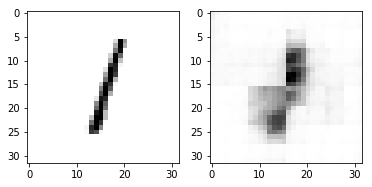

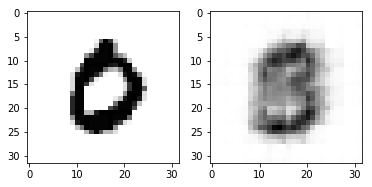

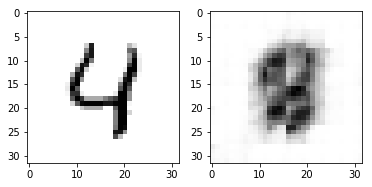

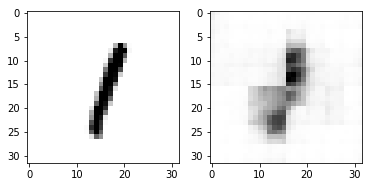

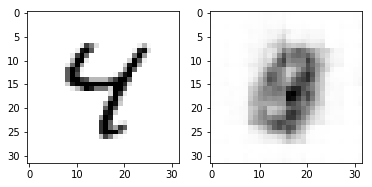

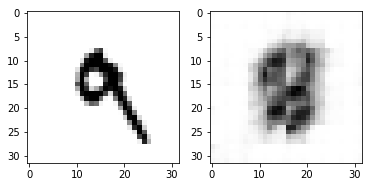

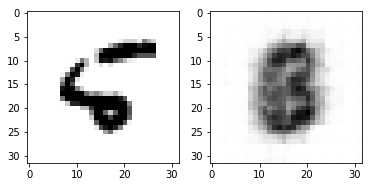

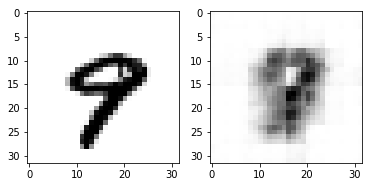

In [53]:
for k in range(10):
    figure()
    subplot(1,2,1)
    imshow(mnist_reshape_32(batch[0][k,:]).reshape((32,32)), cmap = 'gray_r')
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: mnist_reshape_32(batch[0]), training_step : training_step_test, keep_prob : 1})[k,:].reshape((32,32)), cmap = 'gray_r')
    print(tf.argmax(y_cnn, 1).eval(feed_dict={x: mnist_reshape_32(batch[0][k]), training_step : training_step_test, keep_prob : 1}))

(4, 4, 1, 8)


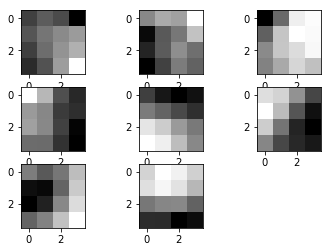

In [54]:
print W_deconv0.eval().shape

for i in range(8):
    plt.subplot(3,3,i+1)
    imshow(W_deconv0.eval()[:,:,0,i].reshape((4,4)), cmap = 'gray_r')

In [55]:
print OUT1, OUT1, DEPTH1
print OUT2, OUT2, DEPTH2
print OUT3, OUT3, DEPTH3

8 8 8
2 2 32
1 1 128


## Saccades algorithm

In [56]:
def gen_x_coords(x, liste_coords, aff = False):
    # coord in 0..7
    assert x.shape == ((32 * 32,))
    image_in = x.reshape((32, 32)) 
    image_out = np.zeros((32, 32))
    if aff:
        image_out += .3
    for u in liste_coords:
        patch = image_in[int(u[0] * 4) : int(u[0] * 4) + 4, int(u[1] * 4) : int(u[1] * 4) + 4]
        image_out[int(u[0] * 4) : int(u[0] * 4) + 4, int(u[1] * 4) : int(u[1] * 4) + 4] = patch
    return image_out.reshape((32 * 32,))

In [57]:
'''liste_coords = [(2, 2), (2, 3), (2, 4), (2, 5),\
                (3, 2), (3, 3), (3, 4), (3, 5),\
                (4, 2), (4, 3), (4, 4), (4, 5),\
                (5, 2), (5, 3), (5, 4), (5, 5)]'''
liste_coords = [(2.5, 2.5), (2.5, 3.5), (2.5, 4.5),\
                (3.5, 2.5), (3.5, 3.5), (3.5, 4.5),\
                (4.5, 2.5), (4.5, 3.5), (4.5, 4.5)]
batch_reduced = np.zeros((BATCH_SIZE, 1024))
for k in range(BATCH_SIZE):
    x_reduced = gen_x_coords(mnist_reshape_32(batch[0])[k], liste_coords)
    batch_reduced[k,:] = x_reduced

(7, 0.95489895, 7)
(2, 0.94140238, 5)
(1, 0.99999952, 1)
(0, 0.68385017, 9)
(4, 0.41573834, 4)
(1, 0.9999994, 1)
(4, 0.52174944, 4)
(9, 0.55006242, 4)
(5, 0.26711583, 4)
(9, 0.4926253, 9)


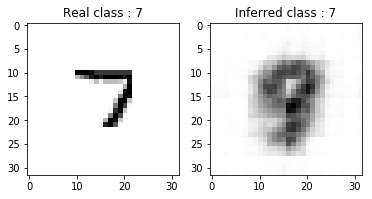

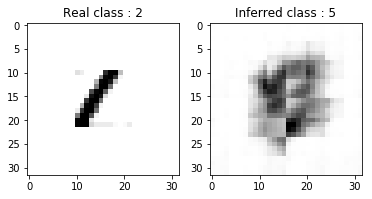

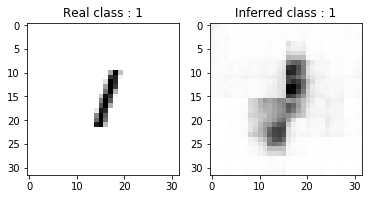

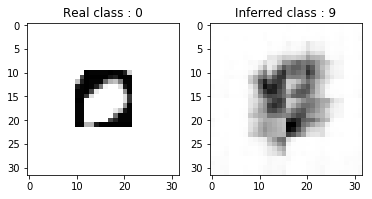

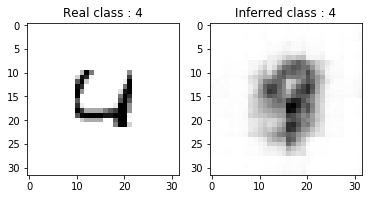

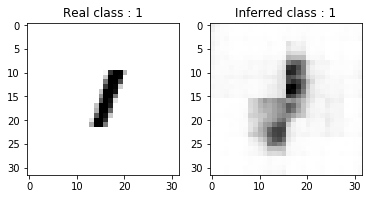

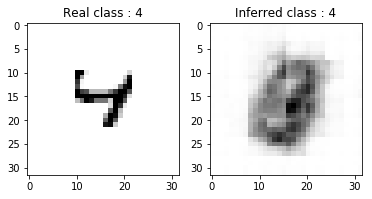

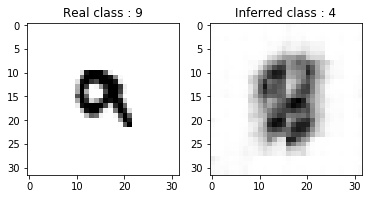

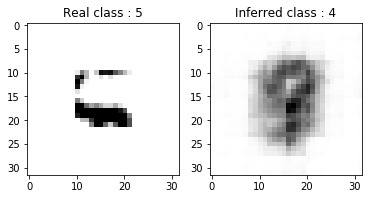

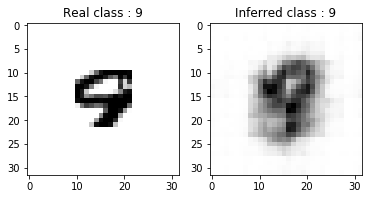

In [58]:
for k in range(10):
    y_real = argmax(batch[1][k])
    y_infer = tf.argmax(y_cnn, 1).eval(feed_dict={x: batch_reduced, training_step : training_step_test, keep_prob : 1})[k]
    figure()
    subplot(1,2,1)
    imshow(batch_reduced[k,:].reshape((32,32)), cmap = 'gray_r')
    title('Real class : ' + str(y_real))
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: batch_reduced, training_step : training_step_test, keep_prob : 1})[k,:].reshape((32,32)), cmap = 'gray_r')
    title('Inferred class : ' + str(y_infer))
    print(y_real,\
          tf.nn.softmax(y_cnn.eval(feed_dict={x: batch_reduced, training_step : training_step_test, keep_prob : 1})[k]).eval()[y_infer],\
          y_infer)

In [ ]:
OFFSET = .5
TURN_MAX = 49 #12
THRESHOLD = .9999

In [ ]:
k = 5

# Data
batch_X = mnist_reshape_32(batch[0])
X = batch_X[k]
batch_X_reduced = np.zeros((BATCH_SIZE, 32 * 32))
batch_classif = batch[1]
# Initialization
U = {}
for i in range(OUT1-1):
    for j in range(OUT1-1):
        U[(i,j)] = 1
u = (3, 3) #(2 + np.random.randint(4), 2 + np.random.randint(4))
liste_u = np.array([u])
U.pop(u)
# fill batch_X_reduced
X_reduced = gen_x_coords(batch_X[k], liste_u + OFFSET)
batch_X_reduced[k] = X_reduced
mem_X_reduced = [X_reduced]
# prior
q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : training_step_test})).eval()[0]
mem_q = np.zeros((OUT1 * OUT1 + 1, 10))
mem_q[0, :] = [.1] * 10
mem_q[1, :] = q
current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0]
max_hyp = argmax(q) 
#current_hyp = 
#print q, current_hyp, argmax(batch_classif[k])
turn = 1
while turn < TURN_MAX and q[max_hyp] < THRESHOLD: #OUT1 * OUT1):
    print turn, str(argmax(batch_classif[k])), max_hyp, q[max_hyp]
    f = plt.figure()
    plt.subplot(1,2,1)
    X_reduced_aff = gen_x_coords(batch_X[k], liste_u + OFFSET, aff = True)
    plt.imshow(X_reduced_aff.reshape((32,32)), cmap = 'gray_r', vmin = 0, vmax = 1)
    title('saccade #' +  str(turn) + ', real class = ' + str(argmax(batch_classif[k])))
    # affichage
    i_N = 4 * (liste_u[-1][0] + OFFSET) - .5
    i_S = 4 * (liste_u[-1][0] + OFFSET) + 3.5
    j_W = 4 * (liste_u[-1][1] + OFFSET) - .5
    j_E = 4 * (liste_u[-1][1] + OFFSET) + 3.5

    plt.plot([j_W, j_E], [i_N, i_N],'r')
    plt.plot([j_W, j_W], [i_N, i_S], 'r')
    plt.plot([j_W, j_E], [i_S, i_S], 'r')
    plt.plot([j_E, j_E], [i_N, i_S], 'r')
    xlim([-0.5, 31.5])
    ylim([-0.5, 31.5])
    plt.gca().invert_yaxis()
    
    X_generated = x_out.eval(feed_dict={x: batch_X_reduced, \
                                        training_step : training_step_test})[k,:]
    plt.subplot(1,2,2)
    plt.imshow(X_generated.reshape((32,32)), cmap = 'gray_r', vmin = 0, vmax = 1)
    plt.title('hyp = ' + str(max_hyp) + ' (' + str(q[max_hyp]) + ')')
    gen_images = {}
    batch_X_patch = np.zeros((len(U), 32 * 32))
    dict_u = {}
    for i, u_gen in enumerate(U):
        dict_u[i] = u_gen
        batch_X_patch[i,:] = gen_x_coords(X_generated, [(u_gen[0] + OFFSET, u_gen[1] + OFFSET)])
    q_gen = tf.nn.softmax(y_cnn.eval(feed_dict={x: batch_X_patch,\
                                                training_step : training_step_test})).eval()
    i_max = np.where(q_gen[:, current_hyp] == max(q_gen[:, current_hyp]))[0][0]
    u_max = dict_u[i_max]
    
    # affichage
    i_N = 4 * (u_max[0] + OFFSET) - .5
    i_S = 4 * (u_max[0] + OFFSET) + 3.5
    j_W = 4 * (u_max[1] + OFFSET) - .5
    j_E = 4 * (u_max[1] + OFFSET) + 3.5

    plt.plot([j_W, j_E], [i_N, i_N],'r:')
    plt.plot([j_W, j_W], [i_N, i_S], 'r:')
    plt.plot([j_W, j_E], [i_S, i_S], 'r:')
    plt.plot([j_E, j_E], [i_N, i_S], 'r:')
    
    i_prec = 4 * (liste_u[-1][0] + .5) + 1.5
    j_prec = 4 * (liste_u[-1][1] + .5) + 1.5
    i_new = 4 * (u_max[0] + .5) + 1.5
    j_new = 4 * (u_max[1] + .5) + 1.5
    
    plt.plot([j_prec, j_new], [i_prec, i_new], 'r')
    plt.plot([j_prec], [i_prec], 'rx')
    plt.plot([j_new], [i_new], 'rx')
    
    #plt.gca().invert_xaxis()
    xlim([-0.5, 31.5])
    ylim([-0.5, 31.5])
    plt.gca().invert_yaxis()
    
    liste_u = np.append(liste_u, np.array([u_max]), axis = 0)
    #print liste_u
    U.pop(u_max)
    X_reduced = gen_x_coords(batch_X[k], liste_u + OFFSET)
    batch_X_reduced[k] = X_reduced
    mem_X_reduced += [X_reduced]
    q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : training_step_test})).eval()[0]
    q = q / np.sum(q)
    turn += 1
    mem_q[turn, :] = q
    #print q, argmax(q), argmax(batch_classif[k])
    current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0] #
    max_hyp = argmax(q) #
    
current_hyp = argmax(q)
print  'Nb saccades :', turn, 'real_class = ', str(argmax(batch_classif[k])), 'estim class = ', str(current_hyp) 
f = plt.figure()
plt.subplot(1,2,1)
X_reduced_aff = gen_x_coords(batch_X[k], liste_u + OFFSET, aff = True)
plt.imshow(X_reduced_aff.reshape((32,32)), cmap = 'gray_r', vmin = 0, vmax = 1)
title('saccade #' +  str(turn) + ', real class = ' + str(argmax(batch_classif[k])))
plt.subplot(1,2,2)
plt.imshow(X_generated.reshape((32,32)), cmap = 'gray_r', vmin = 0, vmax = 1)
plt.title('final hyp = ' + str(current_hyp) + ' (' + str(q[current_hyp]) + ')')

f = figure()
p = plot(mem_q[:turn + 1,:])
xlim([0, TURN_MAX])
ylim([0, 1])
#handles, labels = f.  get_legend_handles_labels()
title('Posterior distribution')
f.legend(p, range(10))
xlabel('saccade #')
#image = 

In [ ]:
q

In [ ]:
mem_mem_q = []
mem_liste_u = []
mem_classif = []
mem_class = []
mem_final_hyp = []
mem_turn = []
for num_batch in range(20):
    batch = mnist.test.next_batch(BATCH_SIZE) 
    for k in range(BATCH_SIZE):
        print num_batch * 20 + k
        batch_X = mnist_reshape_32(batch[0])
        X = batch_X[k]
        batch_X_reduced = np.zeros((BATCH_SIZE, 32 * 32))
        batch_classif = batch[1]
        # Initialization
        U = {}
        for i in range(OUT1-1):
            for j in range(OUT1-1):
                U[(i,j)] = 1
        u = (3, 3) #(2 + np.random.randint(4), 2 + np.random.randint(4))
        liste_u = np.array([u])
        U.pop(u)
        # fill batch_X_reduced
        X_reduced = gen_x_coords(batch_X[k], liste_u + OFFSET)
        batch_X_reduced[k] = X_reduced
        mem_X_reduced = [X_reduced]
        # prior
        mem_q = np.zeros((OUT1 * OUT1 + 1, 10))
        mem_q[0, :] = [.1] * 10
        q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : training_step_test})).eval()[0]
        mem_q[1, :] = q
        current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0]
        max_hyp = argmax(q) 
        #current_hyp = 
        #print q, current_hyp, argmax(batch_classif[k])
        turn = 1
        while turn < TURN_MAX and q[max_hyp] < THRESHOLD: #OUT1 * OUT1):

            X_generated = x_out.eval(feed_dict={x: batch_X_reduced, \
                                                training_step : training_step_test})[k,:]

            batch_X_patch = np.zeros((len(U), 32 * 32))
            dict_u = {}
            for i, u_gen in enumerate(U):
                dict_u[i] = u_gen
                batch_X_patch[i,:] = gen_x_coords(X_generated, [(u_gen[0] + OFFSET, u_gen[1] + OFFSET)])
            q_gen = tf.nn.softmax(y_cnn.eval(feed_dict={x: batch_X_patch,\
                                                        training_step : training_step_test})).eval()
            i_max = np.where(q_gen[:, current_hyp] == max(q_gen[:, current_hyp]))[0][0]
            u_max = dict_u[i_max]

            liste_u = np.append(liste_u, np.array([u_max]), axis = 0)
            #print liste_u
            U.pop(u_max)
            X_reduced = gen_x_coords(batch_X[k], liste_u + OFFSET)
            batch_X_reduced[k] = X_reduced
            mem_X_reduced += [X_reduced]
            q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : training_step_test})).eval()[0]
            turn += 1
            mem_q[turn, :] = q
            #print q, argmax(q), argmax(batch_classif[k])
            current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0] #
            max_hyp = argmax(q) #

        current_hyp = argmax(q)
        print  'Nb saccades :', turn, ', real_class = ', str(argmax(batch_classif[k])), 'estim class = ', str(current_hyp) 


        #f = figure()
        #p = plot(mem_q[:turn + 1,:])
        #xlim([0, TURN_MAX])
        #ylim([0, 1])
        #title('Posterior distribution')
        #f.legend(p, range(10))
        #xlabel('saccade #')

        mem_mem_q += [mem_q] 
        mem_liste_u += [mem_liste_u] 
        mem_classif += [argmax(batch_classif[k]) == current_hyp]
        mem_turn += [turn]
        mem_class += [argmax(batch_classif[k])]
        mem_final_hyp += [current_hyp]

In [ ]:
print mean(mem_turn)
print mean(mem_classif)

In [ ]:
print mean(mem_turn)
print mean(mem_classif)

In [ ]:
mem_turn_49 = np.copy(mem_turn)
mem_classif_49 = np.copy(mem_classif)
h = hist(mem_turn_49, 49)

im = np.zeros(1024)
for liste_u in mem_liste_u:
    tmp = gen_x_coords(np.ones(1024), np.array(liste_u) + OFFSET)
    im += tmp
imshow(im.reshape(32, 32))

In [ ]:
# 643 saccades (max 49) : TURN MAX
mean(mem_turn) : 19.6562986003
mean(mem_classif) : 0.858475894246
    
# Idea : the model hs learned that theinformation is in the center

In [ ]:
print mean(mem_turn)
print mean(mem_classif)